# [모듈 2.1] 모델 학습, 튜닝 하여 2개의 모델 생성


---


NLP 라이브러리를 [spacy](https://spacy.io/)  사용하여 텍스트 토큰나이징을 하고 Amazon SageMaker [BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext) 알고리즘을 사용하여 분류 모델을 학습합니다.



# 1. 환경 셋업

In [1]:
%load_ext autoreload
%autoreload 2

# 2. 데이터 준비



## 2.1. 데이터 다운로드
아마존 상품 고객 리뷰 [Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) 데이터 세트 다운로드

In [2]:
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz reviews.tsv.gz

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz to ./reviews.tsv.gz


리뷰를 로드하고 리뷰 제목, 본문 및 별표 평점을 선택합니다(약 30초 소요).

## 2.2. 데이터 로딩

In [3]:
%%time
import pandas as pd

# Load a sample of the rows
df_reviews = pd.read_csv('reviews.tsv.gz', compression='gzip', error_bad_lines=False, #nrows=1000,
                         sep='\t', usecols=['product_id', 'product_title',
                                            'review_headline', 'review_body', 'star_rating',
                                            'helpful_votes', 'total_votes']).dropna()
df_reviews.info()

<timed exec>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.




<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090980 entries, 0 to 3091102
Data columns (total 7 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   product_id       object
 1   product_title    object
 2   star_rating      int64 
 3   helpful_votes    int64 
 4   total_votes      int64 
 5   review_headline  object
 6   review_body      object
dtypes: int64(3), object(4)
memory usage: 188.7+ MB
CPU times: user 34.7 s, sys: 2.07 s, total: 36.8 s
Wall time: 36 s


In [4]:
df_reviews.head()

,product_id,product_title,star_rating,helpful_votes,total_votes,review_headline,review_body
0,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,5,0,0,Five Stars,As described.
1,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",5,0,0,It works as advertising.,It works as advertising.
2,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,5,1,1,Five Stars,Works pissa
3,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...,1,0,0,One Star,Did not work at all.
4,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker,5,1,1,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...


## 2.3. 피쳐 엔지니어링

- 5개 이상의 투표가 있는 리뷰를 필터링
- helpful_score 를 생성 합니다.
    - helpful_score = helpful_votes / total_votes
- 감성 레이블링
    - star_rating 
        - 0-2: Negative
        - 3: Neutral
        - 4-5: positive

In [5]:
df_reviews = df_reviews[df_reviews['total_votes'] >= 5]
df_reviews['helpful_score'] = df_reviews['helpful_votes'] / df_reviews['total_votes']
df_reviews['sentiment'] = pd.cut(df_reviews['star_rating'], bins=[0,2,3,6], labels=['Negative','Nuetral','Positive'])
df_reviews.head(2)

,product_id,product_title,star_rating,helpful_votes,total_votes,review_headline,review_body,helpful_score,sentiment
18,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,2,4,5,It does not copy CD-R s to USB as advertised ...,It does not copy CD-R s to USB as advertised. ...,0.800000,Negative
41,B00NG57H4S,Sony MDRZX110 Noise Cancelling Headphones,5,19,23,Great noise cancelling headphones for the price!,Great pair of headphones for the price. If you...,0.826087,Positive


In [6]:
df_reviews.describe()

,star_rating,helpful_votes,total_votes,helpful_score
count,291168.000000,291168.000000,291168.000000,291168.000000
mean,3.391341,15.939169,19.677993,0.741840
std,1.644254,67.884014,70.942305,0.279288
min,1.000000,0.000000,5.000000,0.000000
25%,2.000000,4.000000,6.000000,0.600000
50%,4.000000,7.000000,9.000000,0.833333
75%,5.000000,13.000000,16.000000,0.968750
max,5.000000,12786.000000,12944.000000,1.000000


## 2.4. Sentiment 별로 helpful_score 가시화

- 감성별로 그룹화된 helpful_score 를 시각0화합니다. 
- 우리는 높은 helpful_score가 강력한 부정적 또는 긍정적 리뷰와 상관관계가 있음을 검증할 수 있습니다.

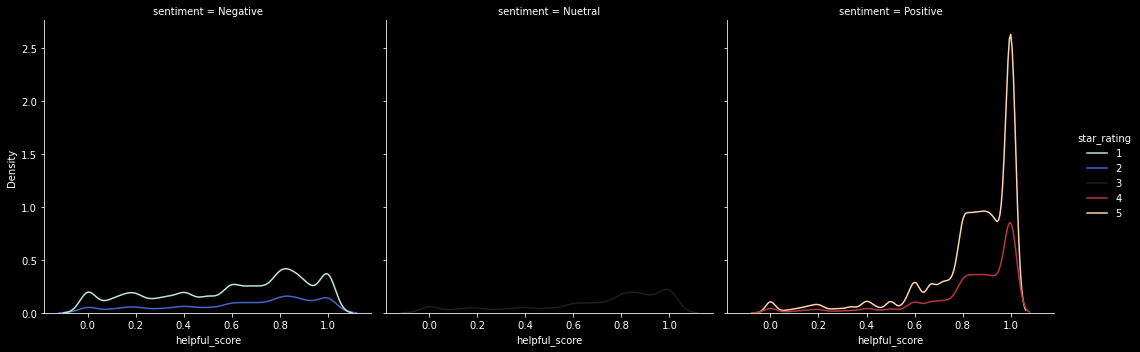

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("dark_background")
sns.displot(df_reviews, x='helpful_score', col='sentiment', hue='star_rating', kind='kde', palette='icefire')

## 2.5. 최종 데이터 생성
### 리뷰 수, helpful votes, total_votes 제품별로 그룹화 합니다.


In [8]:
df_votes =  df_reviews.groupby('product_id').agg({'product_id': 'count', 'helpful_votes': 'sum', 'total_votes': 'sum'})
df_votes

,product_id,helpful_votes,total_votes
product_id,,,
0141186178,1,15,16
043964383X,1,4,9
0511189877,3,29,31
0528881469,11,241,268
0594451647,4,11,22
...,...,...,...
B013UBL9M8,3,63,63
B013UNH0EM,1,4,7
B013Y156PU,2,11,13


### 필터링
- 최소 1개의 리뷰와 최소 5개의 helpful_votes 가 있는 제품을 필터링합니다.

In [9]:
min_reviews = 1
min_helpful = 5
df_votes = df_votes[(df_votes['product_id']>=min_reviews) & (df_votes['helpful_votes']>=min_helpful)]

### 기존 리뷰와 머지하여 새로운 리뷰 데이터를 생성

In [10]:
df_reviews = df_reviews.merge(df_votes, how='inner', left_on='product_id', right_index=True, suffixes=('','_total'))
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284509 entries, 18 to 3091057
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   product_id           284509 non-null  object  
 1   product_title        284509 non-null  object  
 2   star_rating          284509 non-null  int64   
 3   helpful_votes        284509 non-null  int64   
 4   total_votes          284509 non-null  int64   
 5   review_headline      284509 non-null  object  
 6   review_body          284509 non-null  object  
 7   helpful_score        284509 non-null  float64 
 8   sentiment            284509 non-null  category
 9   product_id_total     284509 non-null  int64   
 10  helpful_votes_total  284509 non-null  int64   
 11  total_votes_total    284509 non-null  int64   
dtypes: category(1), float64(1), int64(6), object(4)
memory usage: 26.3+ MB


### is_helpful 50%가 되도록 helpful_score 컷오프(예: 0.80) 를 선택
- 즉 is_helpful== True 인 것이 50% 이상이 되도록 helpful_score 조절 

In [11]:
df_reviews['is_helpful'] = (df_reviews['helpful_score'] > 0.80)
print(f"is_helpful: True --> {df_reviews['is_helpful'].sum()} , total # of is_helpful:  {df_reviews['is_helpful'].count()}")
print(f"is_helpful rate: {round(df_reviews['is_helpful'].sum()/df_reviews['is_helpful'].count(),4)}")

is_helpful: True --> 157859 , total # of is_helpful:  284509
is_helpful rate: 0.5548


### 최종 리뷰 테이터

In [12]:
df_reviews.head(2)

,product_id,product_title,star_rating,helpful_votes,total_votes,review_headline,review_body,helpful_score,sentiment,product_id_total,helpful_votes_total,total_votes_total,is_helpful
18,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,2,4,5,It does not copy CD-R s to USB as advertised ...,It does not copy CD-R s to USB as advertised. ...,0.8,Negative,48,783,1088,False
43374,B0045EJY90,TEAC CD-P650-B Compact Disc Player with USB an...,5,8,8,this Unit (TEAC CD-P650-B) is excellent. It is...,"For my purposes, this Unit (TEAC CD-P650-B) is...",1.0,Positive,48,783,1088,True


## 2.6. Train/Test 분리

데이터 세트를 훈련(90%) / 검증(5%) / 테스트(5%)로 분할하고 파일 로컬 파일에 저장합니다.

In [13]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_reviews, test_size=0.1, random_state=42) 
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)
print('split train: {}, val: {}, test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

split train: 256058, val: 14225, test: 14226 


평가를 위해 테스트 데이터 세트 저장

In [14]:
test_df.to_csv('test.csv', index=False, header=True)

## 2.7. blazing text 알고리즘에 맞게 데이터 포맷 수정
데이터 세트에서 blazing text 레이블 및 토큰화된 텍스트를 출력하는 함수 정의

In [15]:
from spacy.lang.en import English

index_to_label = {0: 'NotHelpful', 1: 'Helpful'} 
nlp = English()
tokenizer = nlp.tokenizer

def labelize_df(df):
    return '__label__' + df['is_helpful'].apply(lambda is_helpful: index_to_label[is_helpful])

def tokenize_sent(sent, max_length=1000):
    return ' '.join([token.text for token in tokenizer(sent)])[:max_length]

def tokenize_df(df):
    return (df['review_headline'].apply(tokenize_sent) + ' ' + 
            df['review_body'].apply(tokenize_sent))

레이블화 및 토큰화 출력 테스트

In [16]:
labelize_df(train_df.head(3)) + ' ' + tokenize_df(train_df.head(3))

2939355    __label__NotHelpful Fantastic speakers ; easy ...
2842286    __label__Helpful Handy Gadget , 3 Easy questio...
3062835    __label__NotHelpful Good player , bad software...
dtype: object

### 레이블 토큰 형태로 데이터 생성
레이블과 토큰을 연결하여 판다 시리즈 데이터를 생성 합니다. (소요 시간: 2분 이내)


In [17]:
%%time
train_text = labelize_df(train_df) + ' ' + tokenize_df(train_df)
val_text = labelize_df(val_df) + ' ' + tokenize_df(val_df)

CPU times: user 2min 26s, sys: 496 ms, total: 2min 26s
Wall time: 2min 26s


### 로컬에 저장
헤더나 인덱스 없이 토큰화된 팬더 시리즈를 텍스트로 저장

In [18]:
%%time
train_text.to_csv('train.txt', index=False, header=False)
val_text.to_csv('validation.txt', index=False, header=False)

CPU times: user 3.36 s, sys: 148 ms, total: 3.51 s
Wall time: 3.51 s


## 2.8. S3 에 업로드 



In [19]:
import sagemaker

# Get the session and default bucket
role = sagemaker.get_execution_role()
session = sagemaker.session.Session()
bucket = session.default_bucket()

# Set the prefix for this dataset
prefix = 'mab-reviews-helpfulness'

s3_train_uri = session.upload_data('train.txt', bucket, prefix + '/data/training')
s3_val_uri = session.upload_data('validation.txt', bucket, prefix + '/data/validation')
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

# 3. 모델 훈련 (Champion 모델 생성)

In [20]:
training_instance_type = "ml.c5.4xlarge"
training_instance_count = 1

In [21]:
import boto3
from sagemaker.estimator import Estimator

region_name = boto3.Session().region_name
image_uri = sagemaker.image_uris.retrieve("blazingtext", region_name)

estimator = Estimator(image_uri=image_uri,
                      role=role, 
                      instance_count=training_instance_count, # Param
                      instance_type=training_instance_type, # Param
                      volume_size = 30,
                      max_run = 360000,
                      input_mode= 'File',
                      output_path=s3_output_location,
                      sagemaker_session=session)

estimator.set_hyperparameters(mode="supervised",
                              epochs=10,
                              min_epochs=5, # Min epochs before early stopping is introduced
                              early_stopping=True,
                              patience=2,
                              learning_rate=0.01,
                              min_count=2, # words that appear less than min_count are discarded 
                              word_ngrams=1, # the number of word n-gram features to use.
                              vector_dim=16, # dimensions of embedding layer
                              )

In [22]:
inputs={
    "train": s3_train_uri,
    "validation": s3_val_uri
}
estimator.fit(inputs, wait=False)

In [23]:
%%time
estimator.logs()

2022-04-17 12:00:31 Starting - Starting the training job...ProfilerReport-1650196831: InProgress
...
2022-04-17 12:01:12 Starting - Preparing the instances for training......
2022-04-17 12:02:28 Downloading - Downloading input data...
2022-04-17 12:03:01 Training - Training image download completed. Training in progress..Arguments: train
[04/17/2022 12:03:03 WARNING 140191350990656] Loggers have already been setup.
[04/17/2022 12:03:03 WARNING 140191350990656] Loggers have already been setup.
[04/17/2022 12:03:03 INFO 140191350990656] nvidia-smi took: 0.025166988372802734 secs to identify 0 gpus
[04/17/2022 12:03:03 INFO 140191350990656] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[04/17/2022 12:03:03 INFO 140191350990656] Processing /opt/ml/input/data/train/train.txt . File size: 162.49529361724854 MB
[04/17/2022 12:03:03 INFO 140191350990656] Processing /opt/ml/input/data/validation/validation.txt . File size: 9

In [24]:
# champion_train_job = estimator.latest_training_job.job_name
# champion_train_job

# 4. 모델 튜닝 (Challenger 모델 생성) 

튜닝 작업을 실행하여 정확도를 최대화하는 매개변수를 찾고 모델 성능을 높여 보겠습니다.

### Setup Hyperparamter Tuning



In [25]:
import boto3
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

region_name = boto3.Session().region_name
image_uri = sagemaker.image_uris.retrieve("blazingtext", region_name)
print(f'Using container: {image_uri}')

tune_estimator = Estimator(image_uri,
                      role, 
                      instance_count=1, 
                      instance_type='ml.c5.4xlarge',
                      volume_size = 30,
                      max_run = 360000,
                      input_mode= 'File',
                      output_path=s3_output_location,
                      sagemaker_session=session)

tune_estimator.set_hyperparameters(mode="supervised",
                              epochs=10,
                              min_epochs=5, # Min epochs before early stopping is introduced
                              early_stopping=False,
                              learning_rate=0.01,
                              min_count=2, # words that appear less than min_count are discarded 
                              word_ngrams=1, # the number of word n-gram features to use.
                              vector_dim=32, # dimensions of embedding layer
                             )

Using container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1


다음을 사용하여 Amazon SageMaker BlazingText 텍스트 분류 모델을 조정합니다. [hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext-tuning.html).


| Parameter Name | Parameter Type | Recommended Ranges or Values | 
| --- | --- | --- | 
| buckets |  `IntegerParameterRange`  |  \[1000000\-10000000\]  | 
| epochs |  `IntegerParameterRange`  |  \[5\-15\]  | 
| learning\_rate |  `ContinuousParameterRange`  |  MinValue: 0\.005, MaxValue: 0\.01  | 
| min\_count |  `IntegerParameterRange`  |  \[0\-100\]  | 
| mode |  `CategoricalParameterRange`  |  \[`'supervised'`\]  | 
| vector\_dim |  `IntegerParameterRange`  |  \[32\-300\]  | 
| word\_ngrams |  `IntegerParameterRange`  |  \[1\-3\]  | 

In [26]:
hyperparameter_ranges = {'epochs': IntegerParameter(5, 50),
                        'learning_rate': ContinuousParameter(0.005, 0.01),
                        'min_count': IntegerParameter(0, 100),
                        'vector_dim': ContinuousParameter(1, 10),
                        'word_ngrams': IntegerParameter(1, 3),
                        'vector_dim': IntegerParameter(32, 300)}

이제 'HyperparameterTuner' 개체를 만들어 전달합니다.

* 위에서 생성한 'BlazingText' estimator
* 하이퍼파라미터 범위
* 목표 메트릭 이름 및 정의

총 실행할 학습 작업 수 및 병렬로 실행할 수 있는 학습 작업 수와 같은 리소스 구성을 조정합니다.

In [27]:
max_jobs = 12
objective_name = 'validation:accuracy'
tuner = HyperparameterTuner(tune_estimator, 
                            objective_name,
                            hyperparameter_ranges,
                            # tags=project_tags,
                            max_jobs=max_jobs,
                            max_parallel_jobs=3)

### 튜닝 시작

이제 `fit()` 함수를 호출하여 하이퍼파라미터 튜닝 작업을 시작할 수 있습니다. 하이퍼파라미터 조정 작업이 생성된 후 SageMaker 콘솔로 이동하여 완료될 때까지 초매개변수 조정 작업의 진행 상황을 추적할 수 있습니다(약 30분 소요).

In [28]:
input_train = TrainingInput(s3_data=s3_train_uri, content_type="text/plain")
input_val = TrainingInput(s3_data=s3_val_uri, content_type="text/plain")
data_channels = {'train': input_train, 'validation': input_val}

tuner.fit(inputs=data_channels, wait=False)

In [29]:
%%time

tuner.wait()

............................................................................................................................................................................................................................................................!
CPU times: user 1.03 s, sys: 77.7 ms, total: 1.11 s
Wall time: 21min 13s


하이퍼파라미터 조정 작업 상태를 빠르게 확인하여 성공적으로 시작되었는지 확인하겠습니다.

In [30]:
import boto3 
from botocore.config import Config

# Create SageMaker client with up to 10 retries
config = Config(retries={"max_attempts": 10, "mode": "standard"})
sm_client = boto3.client('sagemaker', config=config)

In [31]:
job_name = tuner.latest_tuning_job.job_name
tuning_job_status = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name)['HyperParameterTuningJobStatus']
if tuning_job_status != 'Completed':
    raise Exception(f'Tuning Jobs status is {tuning_job_status}')

## 튜닝 작업 분석

목표 메트릭별로 정렬된 교육 작업의 상위 목록을 가져옵니다.

In [32]:
tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(job_name)
jobs_df = tuner_analytics.dataframe()
jobs_df = jobs_df[jobs_df['TrainingJobStatus'] == 'Completed'].sort_values('FinalObjectiveValue', ascending=False)
jobs_df.head()

,epochs,learning_rate,min_count,vector_dim,word_ngrams,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,49.0,0.009126,85.0,32.0,3.0,blazingtext-220417-1203-012-75bf6c21,Completed,0.6809,2022-04-17 12:22:49+00:00,2022-04-17 12:24:16+00:00,87.0
2,46.0,0.005377,93.0,259.0,1.0,blazingtext-220417-1203-010-837e4c77,Completed,0.6758,2022-04-17 12:19:37+00:00,2022-04-17 12:20:39+00:00,62.0
4,44.0,0.008167,47.0,239.0,3.0,blazingtext-220417-1203-008-81367c14,Completed,0.6758,2022-04-17 12:15:41+00:00,2022-04-17 12:20:08+00:00,267.0
5,34.0,0.005362,36.0,260.0,1.0,blazingtext-220417-1203-007-42193dda,Completed,0.6758,2022-04-17 12:15:43+00:00,2022-04-17 12:16:55+00:00,72.0
3,49.0,0.005000,66.0,269.0,1.0,blazingtext-220417-1203-009-89b01d8e,Completed,0.6742,2022-04-17 12:19:07+00:00,2022-04-17 12:20:54+00:00,107.0


# 5. 변수 저장
- champion, challenger 모델 아티펙트 저장
- 모델 훈련 및 튜닝에 사용한 Blazing Text 도커 이미지 (학습, 추론 모두 사용)의 경로 저장

In [33]:
champion_model_artifact = estimator.model_data
print("\nchampion_model_artifact: \n", champion_model_artifact)

best_estimator = tuner.best_estimator()
challenger_model_artifact = best_estimator.model_data
print("\nchallenger_model_artifact: \n", challenger_model_artifact)

model_train_inference_docker_uri = estimator.image_uri
print("\nmodel_train_inference_docker_uri: \n", model_train_inference_docker_uri)




champion_model_artifact: 
 s3://sagemaker-us-east-1-189546603447/mab-reviews-helpfulness/output/blazingtext-2022-04-17-12-00-31-572/output/model.tar.gz

2022-04-17 12:24:16 Starting - Preparing the instances for training
2022-04-17 12:24:16 Downloading - Downloading input data
2022-04-17 12:24:16 Training - Training image download completed. Training in progress.
2022-04-17 12:24:16 Uploading - Uploading generated training model
2022-04-17 12:24:16 Completed - Training job completed

challenger_model_artifact: 
 s3://sagemaker-us-east-1-189546603447/mab-reviews-helpfulness/output/blazingtext-220417-1203-012-75bf6c21/output/model.tar.gz

model_train_inference_docker_uri: 
 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1


In [34]:
%store model_train_inference_docker_uri
%store champion_model_artifact
%store challenger_model_artifact

Stored 'model_train_inference_docker_uri' (str)
Stored 'champion_model_artifact' (str)
Stored 'challenger_model_artifact' (str)


# 참고:  하이퍼 파라미터 연관 관계 분석

목표 측정항목과 조정하기 위해 선택한 개별 하이퍼파라미터 간의 상관관계를 알고 싶을 수 있습니다.

In [35]:
import bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

output_notebook()

class HoverHelper():
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )
        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

def compare_metrics(tuner_analytics, jobs_df):
    hover = HoverHelper(tuner_analytics)
    figures = []
    for hp_name, hp_range in tuner_analytics.tuning_ranges.items():
        categorical_args = {}
        if hp_range.get('Values'):
            # This is marked as categorical.  Check if all options are actually numbers.
            def is_num(x):
                try:
                    float(x)
                    return 1
                except:
                    return 0           
            vals = hp_range['Values']
            if sum([is_num(x) for x in vals]) == len(vals):
                # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
                print(f"Hyperparameter {hp_name} is tuned as categorical, but all values are numeric")
            else:
                # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
                categorical_args['x_range'] = vals

        # Now plot it
        p = figure(plot_width=500, plot_height=500, 
                   title=f"Objective vs {hp_name}",
                   tools=hover.tools(),
                   x_axis_label=hp_name, y_axis_label=objective_name,
                   **categorical_args)
        p.circle(source=jobs_df, x=hp_name, y='FinalObjectiveValue')
        figures.append(p)
    show(bokeh.layouts.Column(*figures))
    
compare_metrics(tuner_analytics, jobs_df)

Loading BokehJS ...